---
# Modelling hippocampal neurons of animals <br> navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; University College London (UCL)
---

#### Outline
**Part 1: Rat simulation in 3D**
- Motion model with `RatInABox`

- Environment design

- Simulated rat vision with `ratvision`

**Part 2: Vision autoencoder**

**Part 3: Hippocampus model with RNN**

**Part 4: Hidden state representations analysis**
- Rate maps

- Polar maps

- Quantitive metrics

- Comparison with *in vivo* recordings

---
## **Part 2: Vision Autoencoder**

In this notebook, we will write code in **Pytorch** to train an **autoencoder** that works with images. An autoencoder is a pair of artificial neural networks that compresses information into a low-dimensional embedding through the first module (aka encoder) and reconstructs it to its original form through the second module (aka decoder).

Neuroscientists use vision autoencoders to model how neurons might represent visual stimuli in the brain [1]. The visual cortex receives complex images and it is able to extract key features into more compact forms (low-dimensional embedding). This non-linear dimensionality reduction process, along with the reconstruction of the original image, can be compared to an autoencoder.

Before starting this notebook, make sure you have:
- video recordings from part 1.

### 0. Install and import dependencies

In [1]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### 1. Visualize example frame

We load vision data from 26 trials of length 720 seconds at 10 Hz, for a total of 187,200 frames.

In [3]:
IMG_DIM = (64, 128) # (height, width) of the input images
GS = True # whether to use grayscale images

In [4]:
d = '../data/vision_ae_data'

trial_paths = [p for p in Path(d).iterdir() if 'exp' in p.name]

trial_paths

[PosixPath('../data/vision_ae_data/exp_dim0.635_fps10_s720_seed04'),
 PosixPath('../data/vision_ae_data/exp_dim0.635_fps10_s720_seed03'),
 PosixPath('../data/vision_ae_data/exp_dim0.635_fps10_s720_seed01'),
 PosixPath('../data/vision_ae_data/exp_dim0.635_fps10_s720_seed02'),
 PosixPath('../data/vision_ae_data/exp_dim0.635_fps10_s720_seed05')]

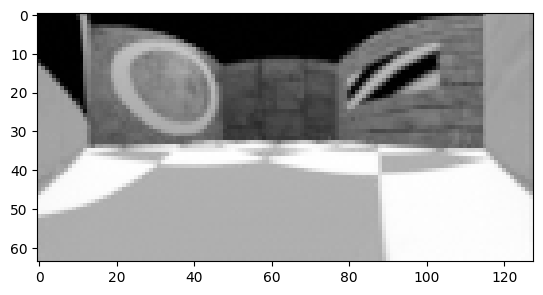

In [5]:
frame_example = trial_paths[0] / 'box_messy' / 'frame0001.png'
plt.imshow(np.array(Image.open(frame_example)), cmap='gray')
plt.show()

### 2. Load frames

The `preprocess_frame` function accepts the path to a frame, then converts it to RGB (or grayscale) values and normalises it 1. The output is a `(channels, height, width)` array of numbers between 0 and 1.

In [6]:
def preprocess_frame(frame, grayscale):
    img = Image.open(frame)
    if grayscale: 
        img = img.convert('L')
    img = np.array(img, dtype=np.float32)

    # normalise RGB to (0, 1) scale
    img = img / 255.
    
    if grayscale:
        img = img[None, ...] # (1, h, w) if grayscale
    else:
        img = np.moveaxis(img, -1, 0) # reshape to (3, h, w) if RGB

    return img

def preprocess_frame_batch(all_frames, batch_indices, grayscale):
    # preprocess a batch of frames
    imgs = np.array([
        preprocess_frame(all_frames[idx], grayscale)
        for idx in batch_indices
    ])
    return imgs

In [7]:
globs = [(tp/'box_messy').glob('*.png') for tp in trial_paths]
all_frames = [f for g in globs for f in g]

We split the frames into a set used for training and a set used to test the model.

In [8]:
# Split dataset into train and test sets
BATCH_SIZE = 32
TEST_SET_PROP = 0.1 # 10%

train_indices, test_indices = train_test_split(
    np.arange(len(all_frames)), test_size=TEST_SET_PROP,
    shuffle=True, random_state=SEED
)

In [9]:
train_imgs = preprocess_frame_batch(
    all_frames, train_indices, grayscale=GS
)
test_imgs = preprocess_frame_batch(
    all_frames, test_indices, grayscale=GS
)

print(f"Train set shape:\t{train_imgs.shape}")
print(f"Test set shape:\t\t{test_imgs.shape}")

Train set shape:	(32400, 1, 64, 128)
Test set shape:		(3600, 1, 64, 128)


We define the `Dataloader`, which is a special Pytorch class helpful to iterate over samples.

In [10]:
from autoencoder.datasets import UnlabeledDataset

dataloader_train = torch.utils.data.DataLoader(
    UnlabeledDataset(torch.from_numpy(train_imgs)),
    batch_size=BATCH_SIZE, shuffle=True
)
dataloader_test = torch.utils.data.DataLoader(
    UnlabeledDataset(torch.from_numpy(test_imgs)),
    batch_size=BATCH_SIZE, shuffle=True
)

### 3. Vision autoencoder definition

As we mentioned before, an autoencoder is a type of neural network that learns to compress data into a smaller representation (aka embedding) &mdash; through an encoder `VisionEncoder` &mdash; and to reconstruct it &mdash; through a decoder `VisionDecoder`. There is no restriction on the structure of the encoder and the decoder, and they don't need to be symmetric. 

However, since we are processing image frames, **convolutional layers** will be helpful becuase they can:
- capture spatial features like edges, textures, shapes, etc.

- preserve local patterns and share weights across images

- detect features efficiently regardless of position

In [11]:
from autoencoder.vision_ae import VisionEncoder, VisionDecoder

# YOUR CODE HERE (1)
KERNEL_SIZES = [(3,3), (4,4), (4,4), (3,3)] # kernel sizes for the convolutional layers
KERNEL_STRIDES = [1, 2, 2, 1] # strides
CHANNELS = [8, 8, 16, 16] # number of channels

EMBEDDING_DIM = 100 # the number of neurons in the hidden state (aka embedding dimension)

img_dim_out = IMG_DIM

print('Need to make sure all numbers are INTEGERS!\n')
print(f'Input dimension:\t\t{1 if GS else 3}x {IMG_DIM}')
for i in range(len(KERNEL_SIZES)):
    ksize = KERNEL_SIZES[i]
    stride = KERNEL_STRIDES[i]

    img_dim_out = [
        (img_dim_out[i] - ksize[i])/stride + 1
        for i in range(len(IMG_DIM))
    ]
    
    print(f'Intermediate dimension {i+1}:\t{CHANNELS[i]}x {img_dim_out}')

print(f'Flattens to:\t\t\t{np.prod(img_dim_out)*CHANNELS[-1]}\n')


Need to make sure all numbers are INTEGERS!

Input dimension:		1x (64, 128)
Intermediate dimension 1:	8x [62.0, 126.0]
Intermediate dimension 2:	8x [30.0, 62.0]
Intermediate dimension 3:	16x [14.0, 30.0]
Intermediate dimension 4:	16x [12.0, 28.0]
Flattens to:			5376.0



In [12]:
encoder = VisionEncoder(
    vision_embedding_dim = EMBEDDING_DIM,
    img_dim = IMG_DIM,
    grayscale = GS,
    kernel_sizes = KERNEL_SIZES,
    kernel_strides = KERNEL_STRIDES,
    channels = CHANNELS
).to(DEVICE)

decoder = VisionDecoder(
    vision_embedding_dim = EMBEDDING_DIM,
    img_dim_out = encoder.img_dim_out,
    grayscale = GS,
    kernel_sizes = KERNEL_SIZES,
    kernel_strides = KERNEL_STRIDES,
    channels = CHANNELS
).to(DEVICE)

Encoder convolution layer: Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): ReLU()
  (3): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2))
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (5): ReLU()
  (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (8): ReLU()
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (11): ReLU()
)
Final convolution size: 16x[12, 28]
Flattens to 5376

Encoder linear layer: Sequential(
  (0): Linear(in_features=5376, out_features=100, bias=True)
  (1): Sigmoid()
)

Decoder linear layer: Linear(in_features=100, out_features=5376, bias=True)

Decoder convolution layer: Sequential(
  (0): ConvTranspose2d(16, 16, kernel_size=

Now that we have defined our encoder and decoder, let's see an example of the reconstruction.

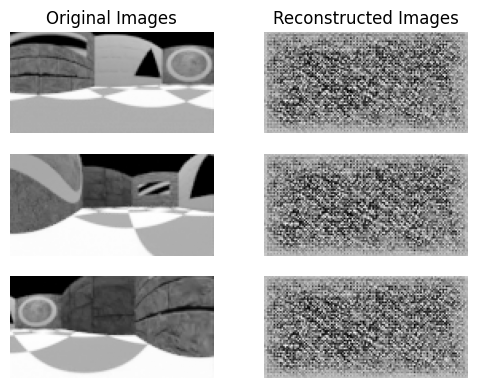

In [13]:
# visualise examples
with torch.no_grad():
    for example_batch in dataloader_test:
        example_batch = example_batch[np.random.choice(len(example_batch), size=3, replace=False)]
        example_batch = example_batch.to(DEVICE)
        example_batch_recon = decoder(encoder(example_batch))

        fig, axs = plt.subplots(len(example_batch), 2, figsize=(6, 1.5*len(example_batch)))
        axs.flat[0].set_title('Original Images')
        axs.flat[1].set_title('Reconstructed Images')
        for i, (frame_example_img, frame_example_recon) in enumerate(zip(example_batch, example_batch_recon)):
            axs[i, 0].imshow(frame_example_img.cpu().numpy().squeeze(), cmap='gray')
            axs[i, 1].imshow(frame_example_recon.cpu().numpy().squeeze(), cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
        plt.show()

        break

This looks like just noise. This is because the autoencoder is not trained yet. But the good news is: at least we got the dimensions correct!

### 4. Autoencoder training

* **Train the model** by comparing its reconstruction to the original image through a self-supervised task.

* If needed, **validate** on the validation set to tune hyperparameters.

* **Test** the trained model on unseen data to evaluate performance.

* Once the model has reached satisfactory performance, embed novel vision data.

We start by defining the train and test loops.

In [14]:
def train_epoch(
    enc, dec,
    dataloader_train,
    loss_fn, optimizer
):
    enc.train()
    dec.train()
    epoch_loss = 0
    
    for batch in dataloader_train:
        optimizer.zero_grad()

        batch = batch.to(DEVICE)
        
        # YOUR CODE HERE (2)
        # forward and backward passes
        batch_recon = dec(enc(batch))
        loss = loss_fn(batch_recon, batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.detach().item()
            
    return epoch_loss / len(dataloader_train)

def test_epoch(
    enc, dec,
    dataloader_test,
    loss_fn,
):
    enc.eval()
    dec.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch in dataloader_test:
            batch = batch.to(DEVICE)
            
            # YOUR CODE HERE (3)
            # forward pass
            batch_recon = dec(enc(batch))
            loss = loss_fn(batch_recon, batch)
            
            epoch_loss += loss.detach().item()
    
    return epoch_loss / len(dataloader_test)

We finalize by setting some important parameters &mdash; such as the number of epochs and the learning rate &mdash; and define the loss function, the optimizer, and (optionally) a learning rate scheduler.

In [15]:
n_epochs = 15 # 200 to perform a full training
learning_rate = 1e-4

loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.RMSprop(
    itertools.chain(encoder.parameters(), decoder.parameters()),
    lr=learning_rate
)

# optional: use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5,
    patience=20, threshold=1e-3
)

We train the model.

Epoch 1/15, Train Loss: 0.0965, Test Loss: 0.0777


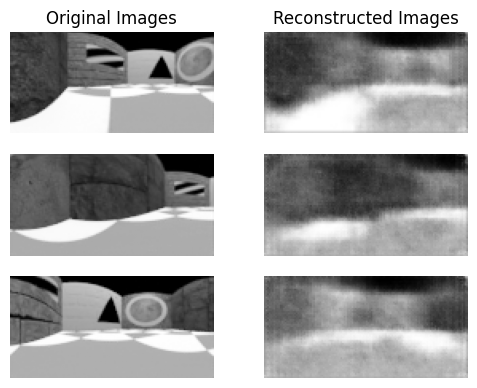

Epoch 2/15, Train Loss: 0.0725, Test Loss: 0.0688
Epoch 3/15, Train Loss: 0.0649, Test Loss: 0.0638
Epoch 4/15, Train Loss: 0.0586, Test Loss: 0.0576
Epoch 5/15, Train Loss: 0.0542, Test Loss: 0.0522


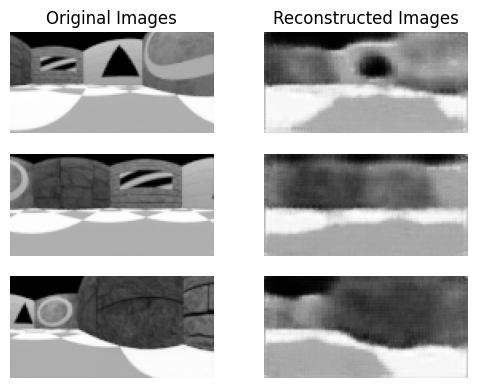

Epoch 6/15, Train Loss: 0.0514, Test Loss: 0.0506
Epoch 7/15, Train Loss: 0.0494, Test Loss: 0.0490
Epoch 8/15, Train Loss: 0.0478, Test Loss: 0.0480
Epoch 9/15, Train Loss: 0.0465, Test Loss: 0.0472
Epoch 10/15, Train Loss: 0.0455, Test Loss: 0.0457


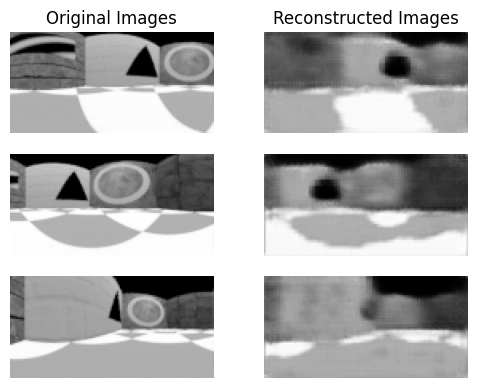

Epoch 11/15, Train Loss: 0.0445, Test Loss: 0.0444
Epoch 12/15, Train Loss: 0.0437, Test Loss: 0.0438
Epoch 13/15, Train Loss: 0.0429, Test Loss: 0.0430
Epoch 14/15, Train Loss: 0.0423, Test Loss: 0.0423
Epoch 15/15, Train Loss: 0.0416, Test Loss: 0.0423


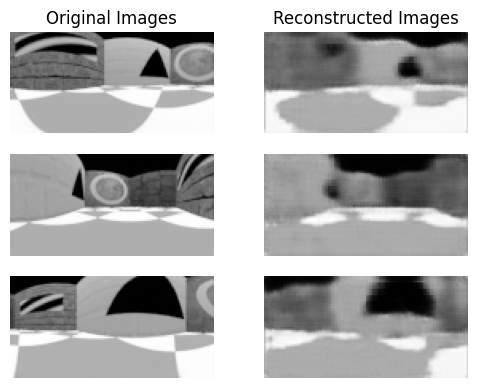

In [16]:
plot_every = 5 # how often to plot examples
train_loss_list = []
test_loss_list = []

for epoch in range(n_epochs):
    train_loss = train_epoch(
        encoder, decoder,
        dataloader_train,
        loss_fn, optimizer
    )
    test_loss = test_epoch(
        encoder, decoder,
        dataloader_test,
        loss_fn
    )
    scheduler.step(test_loss)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # visualize examples
    if epoch == 0 or (epoch+1)%plot_every == 0:
        with torch.no_grad():
            for example_batch in dataloader_test:
                example_batch = example_batch[
                    np.random.choice(len(example_batch), size=3, replace=False)
                ]
                example_batch = example_batch.to(DEVICE)
                example_batch_recon = decoder(encoder(example_batch))

                fig, axs = plt.subplots(len(example_batch), 2, figsize=(6, 1.5*len(example_batch)))
                axs.flat[0].set_title('Original Images')
                axs.flat[1].set_title('Reconstructed Images')
                for i, (frame_example, frame_recon) in enumerate(zip(example_batch, example_batch_recon)):
                    axs[i, 0].imshow(frame_example.detach().cpu().numpy().squeeze(), cmap='gray')
                    axs[i, 1].imshow(frame_recon.detach().cpu().numpy().squeeze(), cmap='gray')
                    axs[i, 0].axis('off')
                    axs[i, 1].axis('off')
                plt.show()
                break


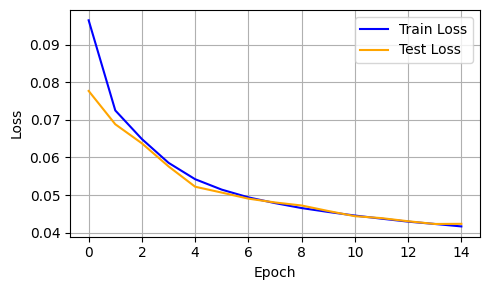

In [17]:
plt.figure(figsize=(5, 3))
plt.plot(range(epoch+1), train_loss_list, label='Train Loss', color='blue')
plt.plot(range(epoch+1), test_loss_list, label='Test Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Train and test loss for a ful training process.

![Train and test loss](train_test_loss.png)

In [18]:
# torch.save(encoder.state_dict(), 'encoder.pth')
# torch.save(decoder.state_dict(), 'decoder.pth')

### 5. Embed rat vision

We load a previously saved model, which was trained by setting the number of epochs to 100 in the previous step. To embed new frames we would just need the **Encoder**, but we also load the **Decoder** to show examples of reconstruction from a performing model.

In [19]:
%%capture

encoder.load_state_dict(torch.load('encoder.pth', weights_only=True))
decoder.load_state_dict(torch.load('decoder.pth', weights_only=True))

encoder = encoder.to(DEVICE)
decoder = decoder.to(DEVICE)

encoder.eval()
decoder.eval()

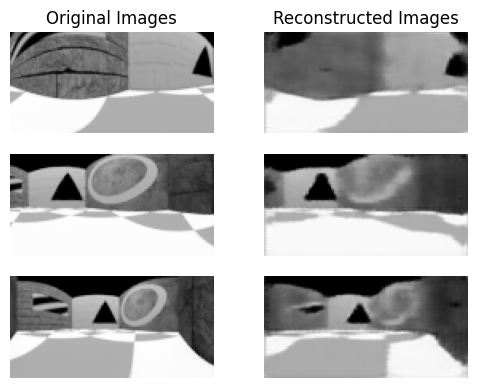

In [20]:
for example_batch in dataloader_test:
    example_batch = example_batch[
        np.random.choice(len(example_batch), size=3, replace=False)
    ]
    example_batch = example_batch.to(DEVICE)
    example_batch_recon = decoder(encoder(example_batch))

    fig, axs = plt.subplots(len(example_batch), 2, figsize=(6, 1.5*len(example_batch)))
    axs.flat[0].set_title('Original Images')
    axs.flat[1].set_title('Reconstructed Images')
    for i, (frame_example, frame_recon) in enumerate(zip(example_batch, example_batch_recon)):
        axs[i, 0].imshow(frame_example.detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, 1].imshow(frame_recon.detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.show()
    break


Load rat vision data and embed it using a trained **Encoder**.

In [21]:
d = '../data/adult'
trial_paths = [p for p in Path(d).iterdir() if 'exp' in p.name]

for tp in trial_paths:
    print(tp)

    frame_paths = sorted([f for f in (tp/'box_messy').glob('*.png')])

    frames = preprocess_frame_batch(
        frame_paths, np.arange(len(frame_paths)), grayscale=GS
    )
    dataloader = torch.utils.data.DataLoader(
        UnlabeledDataset(torch.from_numpy(frames)),
        batch_size=BATCH_SIZE, shuffle=False
    )
    
    batch_emb_all = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)
            
            batch_emb = encoder(batch)
            
            batch_emb_all.append(batch_emb.cpu().numpy())

    batch_emb_all = np.concatenate(batch_emb_all, axis=0)

    print(batch_emb_all.shape)
    np.save(tp/'vision_embeddings.npy', batch_emb_all)
    print(f'Saved embeddings to {tp/"vision_embeddings.npy"}\n')

../data/adult/exp_dim0.635_fps10_s720_seed09
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed09/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed19
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed19/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed24
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed24/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed12
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed12/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed14
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed14/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed13
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed13/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed25
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed25/vision_e

### **Summary: what have we achieved?**

We trained a Vision Autoencoder that can compress images into **embeddings** &mdash; namely smaller representations of the inputs.

These embeddings of the visual scene can be though of as inputs to the hippocampus &mdash; which we model as a **Predictive Recurrent Neural Network** in the next part &mdash; thought to transform egocentric (i.e. self-centred) information into a coherent allocentric (i.e. world-centred) representation. This is crucial to support flexible navigation strategies such as taking shortcuts or planning routes to unseen locations [2].

### References

[1] G. W. Lindsay. Convolutional Neural Networks as a Model of the Visual System: Past, Present, and Future. J Cogn Neurosci, 33(10):2017–2031, 2021.

[2] E. C. Tolman. Cognitive maps in rats and men. Psychological review, 55(4):189, 1948.